# LSTM Forecasting of Earthquake Magnitude

In [1]:
# Prepare libraries
from data.data import EarthquakeData
from dotenv import load_dotenv
from earthquakes.settings import read_coordinates
from pathlib import Path
import numpy as np
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

In [2]:
cwd = Path.home() / "earthquakes"
load_dotenv(cwd / ".env")

(minlat, maxlat), (minlong, maxlong) = read_coordinates()
qdata = EarthquakeData(
    pd.read_csv(Path.home() / "earthquakes/csv/9923ce9a42736848b544e335a4d7c5fb.csv"),
    numeric_columns=["latitude", "longitude", "depth", "mag"],
    zero_columns=["depth", "mag"],
    target="mag",
    time_column=True,
    delta_time=True,
    drop_time_column=True,
    min_latitude=minlat,
    min_longitude=minlong,
    min_magnitude=4,
    scaler_mode='standard',
)
data = qdata.process()
data.describe()

,latitude,longitude,depth,mag,delta
count,3709.000000,3709.000000,3709.000000,3709.000000,3709.000000
mean,0.000738,0.000498,0.000369,0.002904,0.000226
std,0.999258,0.999809,1.000017,0.984505,1.000175
min,-2.738381,-1.847410,-1.369406,-1.121444,-0.837668
25%,-0.545954,-0.893087,-0.863468,-0.650792,-0.697074
50%,0.480700,-0.009117,-0.368263,-0.180141,-0.342676
75%,0.551172,1.003085,1.051428,0.525835,0.357666
max,1.904633,1.218621,5.322765,7.585601,8.492194


['latitude', 'longitude', 'depth', 'mag', 'delta']


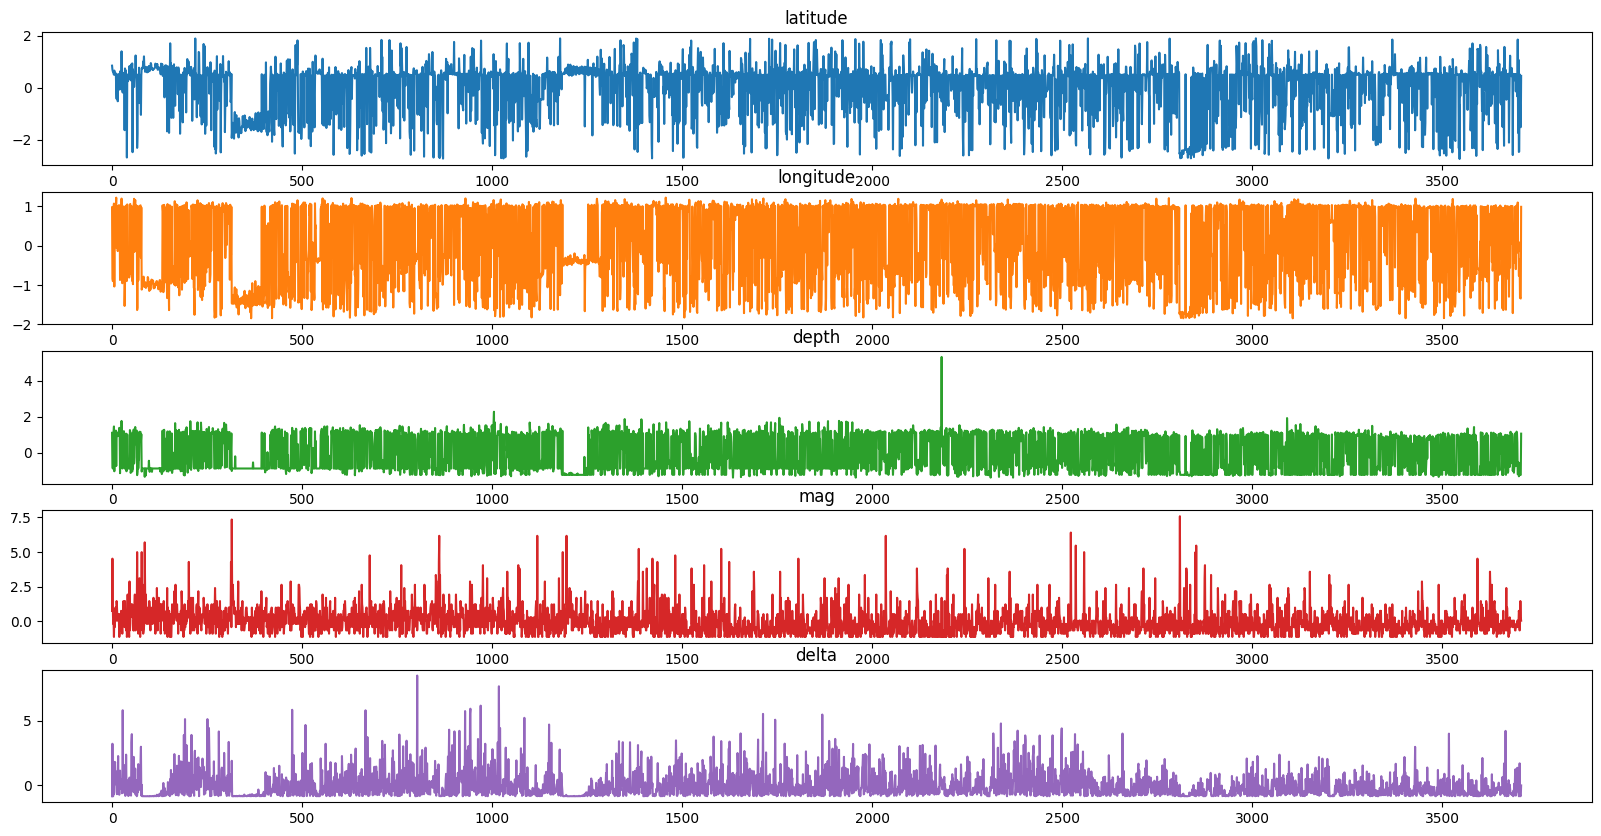

In [3]:
print(qdata.numeric_columns)

def get_color_from_palette(index, palette_name):
    """
    Returns a hex color string from a specified Matplotlib palette.

    Parameters:
    index (int): The index of the color in the palette.
    palette_name (str): The name of the Matplotlib palette.

    Returns:
    str: The hex color string.
    """
    # Get the palette colors
    colors = plt.get_cmap(palette_name).colors
    
    # Ensure the index is within the range of available colors
    if not 0 <= index < len(colors):
        raise ValueError("Index out of range for the specified palette.")
    
    # Convert the color to a hex string
    color = colors[index]
    hex_color = '#{:02x}{:02x}{:02x}'.format(int(color[0]*255), int(color[1]*255), int(color[2]*255))
    
    return hex_color

timeseries = data[qdata.numeric_columns].astype('float32')
features = len(qdata.numeric_columns) 
fig, ax = plt.subplots(features, 1, figsize=(20, 10))
for i in range(features):
    ax[i].plot(timeseries.iloc[:, i], c=get_color_from_palette(i, 'tab10'))
    ax[i].set_title(qdata.numeric_columns[i])
plt.show()

In [4]:
# train-test split for time series
train_size = int(len(timeseries) * 0.85)
test_size = len(timeseries) - train_size
train_size, test_size
# train, test = timeseries[:train_size], timeseries[train_size:]
# train.shape, test.shape
# train, validate, test = np.split(timeseries.sample(frac=1), [int(.6*len(timeseries)), int(.8*len(timeseries))])
# train.shape, validate.shape, test.shape

(3152, 557)

In [5]:
def create_dataset(dataset: pd.DataFrame, lookback):
    """Transform a time series into a prediction dataset
    
    Args:
        dataset: A numpy array of time series, first dimension is the time steps
        lookback: Size of window for prediction
    """
    X, y = [], []
    for i in range(len(dataset)-lookback):
        feature = dataset[i:i+lookback]
        target = dataset.at[i+lookback, qdata.target]
        X.append(feature)
        y.append([target])
        
    X,y = np.array(X), np.array(y)
    return torch.tensor(X), torch.tensor(y)

lookback = 5
batch_size = 10
X_full, y_full = create_dataset(timeseries, lookback=lookback)
X_train, y_train = X_full[:train_size], y_full[:train_size]
X_test, y_test = X_full[train_size:], y_full[train_size:]
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([3152, 5, 5]) torch.Size([3152, 1])
torch.Size([552, 5, 5]) torch.Size([552, 1])


In [18]:
X_train[2], y_train[2]

(tensor([[ 0.6309, -0.9021, -0.8635,  0.9965, -0.8285],
         [ 0.6389, -0.8915, -0.8635, -0.1801, -0.8366],
         [ 0.5476,  0.9629,  1.0990,  0.0552,  1.8333],
         [ 0.5050,  1.0670,  1.4669, -1.1214, -0.6875],
         [ 0.6627, -1.0396, -1.0168,  0.5258, -0.5122]]),
 tensor([-0.4155]))

In [7]:
class ForecastModel(nn.Module):
    def __init__(self):
        super().__init__()
        hidden_size = 50
        self.lstm = nn.LSTM(input_size=features, hidden_size=hidden_size, num_layers=lookback, batch_first=True)
        self.linear = nn.Linear(hidden_size, 1)
    
    def forward(self, x):
        out, _ = self.lstm(x)
        return self.linear(out[:, -1, :])

In [8]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
torch.cuda.is_available()

True

In [9]:

train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, shuffle=False, batch_size=batch_size)
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=batch_size)
model = ForecastModel().to(device)
optimizer = optim.Adam(model.parameters())
loss_fn = nn.MSELoss()


In [10]:
n_epochs = 300
epoch_losses = []
epoch_test_losses = []
for epoch in range(n_epochs):
    model.train()
    epoch_loss = 0
    for X_batch, y_batch in train_loader:
        y_pred = model(X_batch.to(device))
        loss = loss_fn(y_pred, y_batch.to(device))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        
    model.eval()
    with torch.no_grad():
        test_loss = 0
        for X_batch, y_batch in test_loader:
            y_pred = model(X_batch.to(device)).detach().cpu()
            test_loss += loss_fn(y_pred, y_batch).item()
    
    epoch_losses.append(epoch_loss)
    epoch_test_losses.append(test_loss)
    print("Epoch %d: loss %.4f test_loss: %.4f" % (epoch, epoch_loss, test_loss))

Epoch 0: loss 316.9530 test_loss: 31.1096
Epoch 1: loss 320.3049 test_loss: 31.1352
Epoch 2: loss 320.1470 test_loss: 31.1520
Epoch 3: loss 319.1662 test_loss: 31.1206
Epoch 4: loss 320.1680 test_loss: 31.0898
Epoch 5: loss 321.2665 test_loss: 31.1131
Epoch 6: loss 320.7317 test_loss: 31.0949
Epoch 7: loss 320.8023 test_loss: 31.1756
Epoch 8: loss 319.7345 test_loss: 31.1485
Epoch 9: loss 319.0356 test_loss: 31.1042
Epoch 10: loss 318.1065 test_loss: 31.1010
Epoch 11: loss 316.4064 test_loss: 31.0295
Epoch 12: loss 316.2318 test_loss: 31.0562
Epoch 13: loss 314.3768 test_loss: 31.0273
Epoch 14: loss 314.3748 test_loss: 30.9682
Epoch 15: loss 314.3326 test_loss: 30.9695
Epoch 16: loss 310.5284 test_loss: 30.8381
Epoch 17: loss 307.9046 test_loss: 30.7600
Epoch 18: loss 305.4689 test_loss: 31.0522
Epoch 19: loss 304.3260 test_loss: 30.4976
Epoch 20: loss 300.6450 test_loss: 30.8163
Epoch 21: loss 299.2043 test_loss: 31.2487
Epoch 22: loss 295.7110 test_loss: 31.2326
Epoch 23: loss 292.41

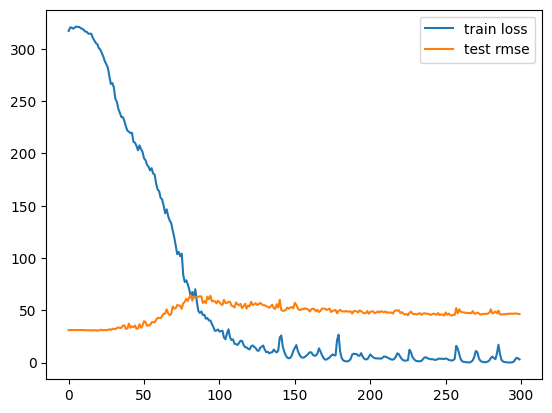

In [11]:
plt.plot(epoch_losses, label='train loss')
plt.plot(epoch_test_losses, label='test rmse')
plt.legend()
plt.show()

(3709, 1) (3709, 1)


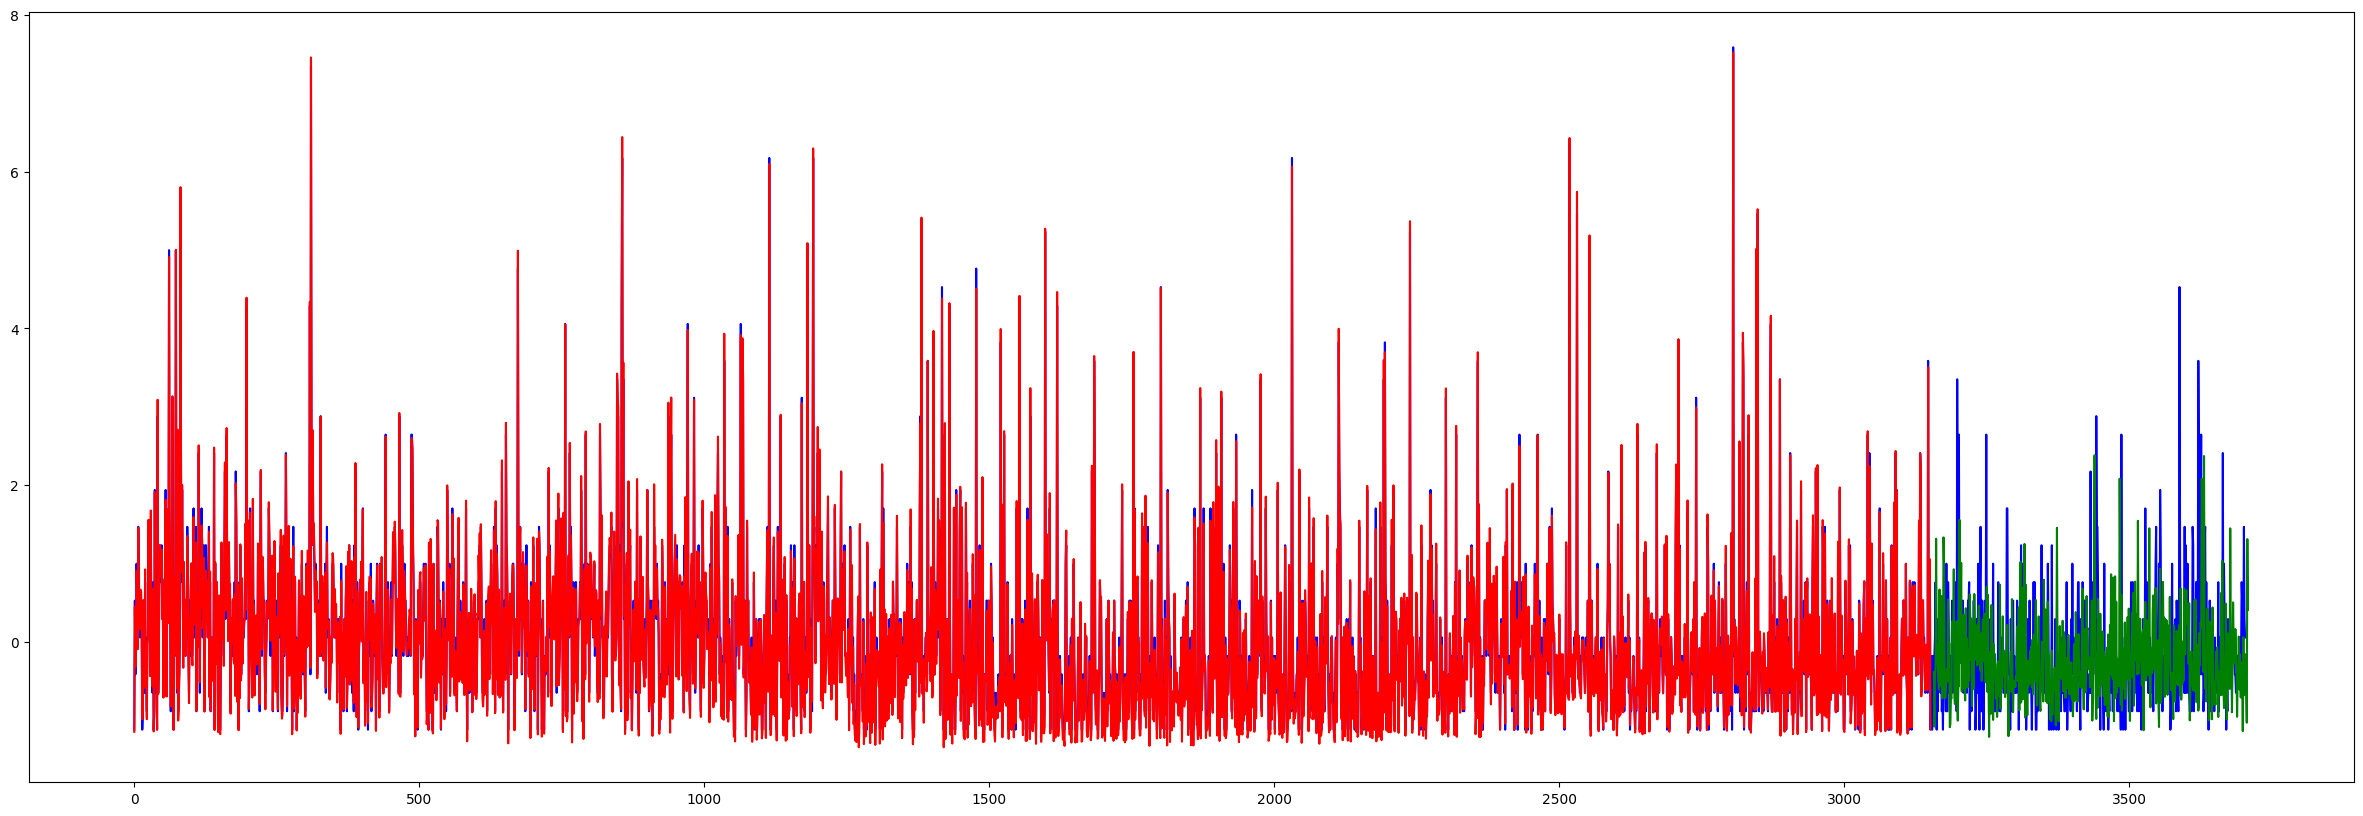

In [16]:
model.eval()
train_plot = np.ones((data.shape[0], 1)) * np.nan
test_plot = np.ones((data.shape[0], 1)) * np.nan

print(train_plot.shape, test_plot.shape)
with torch.no_grad():
    # shift train predictions for plotting
    train_input = torch.Tensor(X_train).to(device)
    train_pred = model(train_input).detach().cpu()
    train_plot[:train_size] = train_pred
    # shift test predictions for plotting
    test_input = torch.Tensor(X_test).to(device)
    test_pred = model(test_input).detach().cpu()
    test_plot[train_size+lookback:] = test_pred

plt.gcf().set_size_inches(30, 10)
plt.plot(np.concatenate([y_train,y_test]), c='b')
plt.plot(train_plot, c='r')
plt.plot(test_plot, c='g')


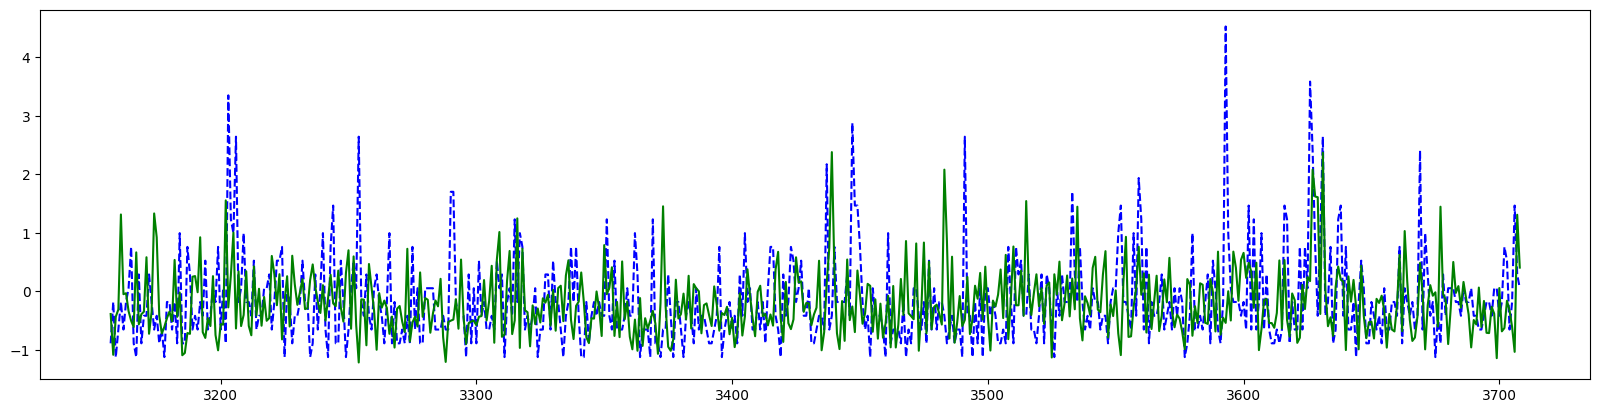

In [19]:
test_plot2 = np.ones((data.shape[0], 1)) * np.nan
test_plot2[train_size+lookback:] = y_test

plt.plot(test_plot2, c='b', linestyle='--')
plt.plot(test_plot, c='g')
plt.gcf().set_figwidth(20)
plt.show()

Hstack (3152, 2)


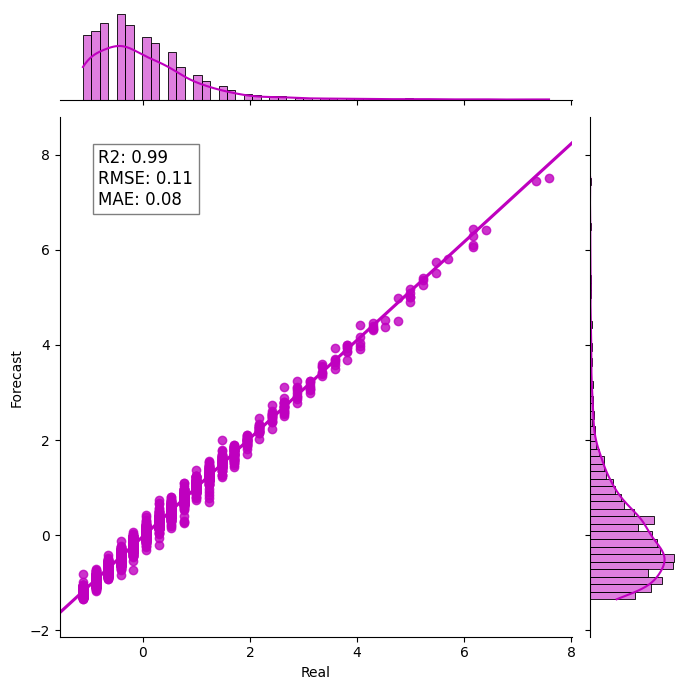

In [20]:
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
original, forecast = y_train.numpy(), train_pred.numpy()
hstack = np.hstack((original, forecast))
print("Hstack", hstack.shape)

g = sns.jointplot(
    x="Real",
    y="Forecast",
    data=pd.DataFrame(hstack, columns=["Real", "Forecast"]),
    kind="reg",
    truncate=False,
    color="m",
    height=7,
)

test_loss = mean_squared_error(original, forecast)
test_mae = mean_absolute_error(original, forecast)
test_r2 = r2_score(original, forecast)
test_rmse = np.sqrt(test_loss)

# Add metrics to the plot
plt.figtext(
    0.15,
    0.70,
    f"R2: {test_r2:.2f}\nRMSE: {test_rmse:.2f}\nMAE: {test_mae:.2f}",
    bbox=dict(facecolor="white", alpha=0.5),
    fontsize=12,
)
plt.show()

Hstack (552, 2)


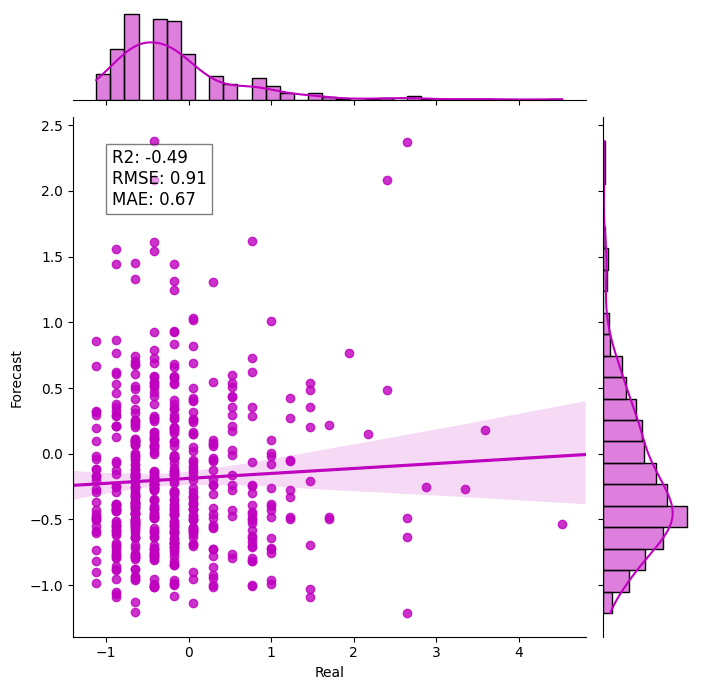

In [21]:
original, forecast = y_test.numpy(), test_pred.numpy()
hstack = np.hstack((original, forecast))
print("Hstack", hstack.shape)

g = sns.jointplot(
    x="Real",
    y="Forecast",
    data=pd.DataFrame(hstack, columns=["Real", "Forecast"]),
    kind="reg",
    truncate=False,
    color="m",
    height=7,
)

test_loss = mean_squared_error(original, forecast)
test_mae = mean_absolute_error(original, forecast)
test_r2 = r2_score(original, forecast)
test_rmse = np.sqrt(test_loss)

# Add metrics to the plot
plt.figtext(
    0.15,
    0.70,
    f"R2: {test_r2:.2f}\nRMSE: {test_rmse:.2f}\nMAE: {test_mae:.2f}",
    bbox=dict(facecolor="white", alpha=0.5),
    fontsize=12,
)
plt.show()